# Data Analyst Professional Practical Exam Submission

### Data and Imports

In [4]:
!pip install path

In [5]:
import pandas
import geopandas
from path import Path
import os
from functools import reduce
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
%matplotlib inline

/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
# set working directory and path to dataset
working_directory = Path.getcwd()
inputs_path = working_directory

# read in dataframe 
df = pandas.read_csv('product_sales.csv')

# view
display(
    df.head(),
    df.shape
)

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NaN,0,24,Arizona
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NaN,3,25,Indiana
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois


(15000, 8)

## Task 1: Data Validation

_Write your answer here_

To begin, I read in the dataframe and created a summary dataframe  **(see the code following this answer)** to view the data types, number of unique values, and number of missing values by column. Question responses are below.

(a) All values matched the description provided by the dataset. <br>

(b) Only one column had a missing values, `revenue`, but this is one of the most important columns of data to analyze.
- Instead of deleting these mising values, I filled the 1074 NaNs from the 15000 row dataset with `0` in the `revenue` column.
- Additionally, I created a separate a categorical column, `sales_made`, to differentiate whether not a sale was made at all. I felt like this would be important when seeing what sales methods were used and if it impacted how much revenue, if any at all, was generated from customers. <br>

(c) Actions performed to make values match the description or clean them up: 
- `sales_method` was had inconsistent spellings for variables. I cleaned up the strings to narrow them down to the three initial categories of `call`, `email`, and `email_and_call`
- `years_as_customer` should be at the most 39 years if a customer started purchasing products at Pens and Printers since it's founding in 1984 and the current year is 2023. Due to this, I found two observations in `years_as_customer` that had the values 47 and 63 which were dropped. This may have been due to a manual input error. 
- `sales_times` was created based on the instructions that mentioned saving time was important. We know calls took 30 minutes, and emails are stated as "little time", so I quantified those to 10 minutes. If it was and email and call (which was noted to be 10 minutes on average) the values equaled 20. 

In [7]:
# view data type columns and see if they match the above
summary_df = pandas.DataFrame(
    [
        [df[column].dtypes, df[column].nunique(), df[column].isna().sum()]
        for column in df.columns
    ],
    index=df.columns,
    columns=['type_', 'nunique', 'nempty']
)
summary_df

,type_,nunique,nempty
week,int64,6,0
sales_method,object,5,0
customer_id,object,15000,0
nb_sold,int64,10,0
revenue,float64,6743,1074
years_as_customer,int64,42,0
nb_site_visits,int64,27,0
state,object,50,0


In [8]:
# clean data

# make email and call into three categories
df.sales_method =df.sales_method.str.lower().str.replace('em ','email').str.replace('+','_and_').str.replace(' ','')

# Each customer_id is unique, but some customers received phone calls and emails. Would be hard to pin whether or not we would be double counting these calls and emails in conjunction. 

# Fill NaNs for revenue with 0 and ensure rounded to 2 decimal places.
df.revenue = df.revenue.fillna(0).round(2)

# Create a categorical column to differentiate these when looking at what was sold
df['sales_made'] = numpy.where(df.revenue ==0, "No","Yes")

# worth looiking into and only keeping valid customers 39 years and under
df = df[df.years_as_customer <= 39]

# Create a categorical column to differentiate these when looking at what was sold
def sales_time(row):
    if row["sales_method"] == "email":
        val = 10
    elif row["sales_method"] == "email_and_call":
        val = 20
    elif row["sales_method"] == "call":
        val = 30        
    else:
        val =  val
    return val

df['sales_time'] = df.apply(sales_time,axis=1)    

/var/folders/cm/dxwv2v512jvdqq0n4y_wjcl40000gn/T/ipykernel_31761/3995984795.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.sales_method =df.sales_method.str.lower().str.replace('em ','email').str.replace('+','_and_').str.replace(' ','')


<div class="alert alert-block alert-info"> <b>Exploratory Analysis</b>
    
<br>How many customers were there for each approach? (1500)
    
What does the spread of the revenue look like overall? And for each method?
    
Was there any difference in revenue over time for each of the methods?</br>

_Write your answer here_

a. 15000 customer_ids were listed initially, which decreased to 14998 after dropping the two observations wtih invalid `years_as_cusomter` values. For each sales method, the spread of revenue  and count of observations by `sales_method` is listed in the table below: 

| sales_method   | revenue (total)     | count (total) | site visits (total) |
| :---        | :----:        |    ---:   |---:   |
| call   | 227513.02   | 4961        | 121164 |
| email   | 672221.61   | 7465        | 184792 |
| email_and_call   | 408256.69   | 2572        | 68856|

- Out of the 14998 observations, revenue and number of observations by each `sales_method` is categorized as:

    * call (Revenue-$227,513.02 Number of Observations - 121164)
    
    * email (Revenue - $672,221.61, Number of Observations - 7465)
    
    * email_and_call (Revenue - $408,256.69, Number of Observations - 2572)

- Calling  generated the least amount of revenue, while `email_and_call` occurred the least. This makes sense as `email_and_call` likely took the same amount of time as the calling the customer at 10 minutes and an email vs. a 30 minute call, but likely more time consuming to search and track.
- In relation to revenue, calling takes the most amoiunt of time and generated the least revenue (nearly 1/3 of the email `sales_method`). Email the most cost-effective as far as time to send out and reach customers, and generated the most revenue.

b. In Figure A and Figure B, you can see the distribution of the revenue as a whole by histogram. Figure B shows a boxplot of revenue where you can see outliers. Visually it appears the data is skewed to the right, although summary stats only show `years_as_customer` being the variable where the median is greater than 50%. This is explored in later observations.

c. Curious about the revenue generated over time by week, especially with some groups recieving both an email and follow-up call.
- Figure C shows a line chart showing revenue over time. Figure D illustrates the distribution of revenue generated by each sales method over the 6 week time frame. 
- Figure C-1 uses a violinplot to capture the distribution masked for whether `sales_made` was equal to "Yes", filtering out the observations that had no revenue, or 0 as a value. 
- Figure C-2 visualizes `sales_made` as a violinplot, but for all sales methods, and whether was generated by an observation or not (i.e. `revenue` == 0). This skewed the data distribution much more.
- <u>Figure D-1: Revenue by Week</u> and <u>D-2: Revenue by Week and Sales Method</u> show revenue distribution by week overall, and by sales method. There is a noticeable uptick in revenue distribution overall and by sales method during week 5 and 6. Most profit generating is `email_and_call` by week 5 and 6. 
- Because methods of communication vary across cultures (and in this case, state geographies), I wondered if the average years someone was a customer and their geographic locaiton might impact the revenue generated by a preferred communication style.
    * <u>Fig E-1: Revenue (Points) by Average Years as Customer and State</u> areas using natural breaks method. with a larger average customer base have fewer revenue sales where this occurs
    * <u>Fig E-2: Average Years as Customer (Points) by Revenue and State</u> using quantiles method, where revenue is concentrated heavily on costal states and there doesn't appear to be a significant difference in average years as customer. 
    * Extracting data by `sales_methodd`, it seemed like upon first glance, <u>Fig F-1: Revenue by Call</u>, <u>Fig F-2: Revenue by Call and Email</u>, <u>Fig F-3: Revenue by Email</u> location of observations showed little variance regarding the spread of revenue by `sales_method` used. 

In [9]:
# check for summary stats

def describe(df, stats):
    d = df.describe()
    return d.append(df.reindex(d.columns, axis = 1).agg(stats))

describe(df, ['var', 'skew'])

/var/folders/cm/dxwv2v512jvdqq0n4y_wjcl40000gn/T/ipykernel_31761/2780718332.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return d.append(df.reindex(d.columns, axis = 1).agg(stats))


,week,nb_sold,revenue,years_as_customer,nb_site_visits,sales_time
count,14998.000000,14998.000000,14998.000000,14998.000000,14998.000000,14998.000000
mean,3.098280,10.084678,87.210983,4.959261,24.990799,18.330444
std,1.656490,1.812334,51.728485,5.011237,3.501100,8.948127
min,1.000000,7.000000,0.000000,0.000000,12.000000,10.000000
25%,2.000000,9.000000,50.602500,1.000000,23.000000,10.000000
50%,3.000000,10.000000,87.575000,3.000000,25.000000,20.000000
75%,5.000000,11.000000,106.070000,7.000000,27.000000,30.000000
max,6.000000,16.000000,238.320000,39.000000,41.000000,30.000000
var,2.743958,3.284554,2675.836119,25.112496,12.257700,80.068968
skew,0.174842,0.765661,0.738333,1.968592,0.005713,0.333243


<Figure size 1500x500 with 0 Axes>

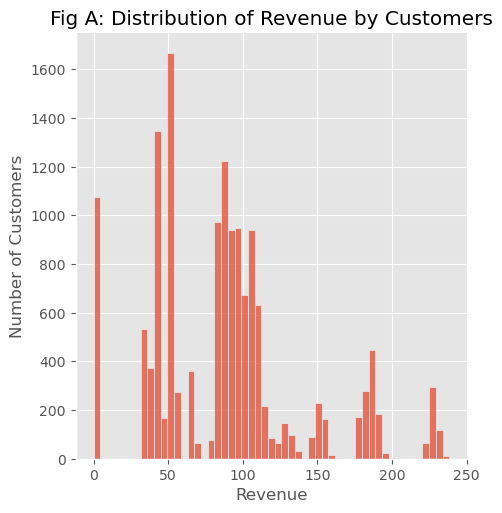

In [10]:
# set plot style and figure size
plt.style.use('ggplot')
fig = plt.figure(figsize=(15, 5))

# histoplot
sns.displot(data=df, x= df['revenue']).set(xlabel='Revenue', ylabel='Number of Customers')
plt.title("Fig A: Distribution of Revenue by Customers")
plt.show()

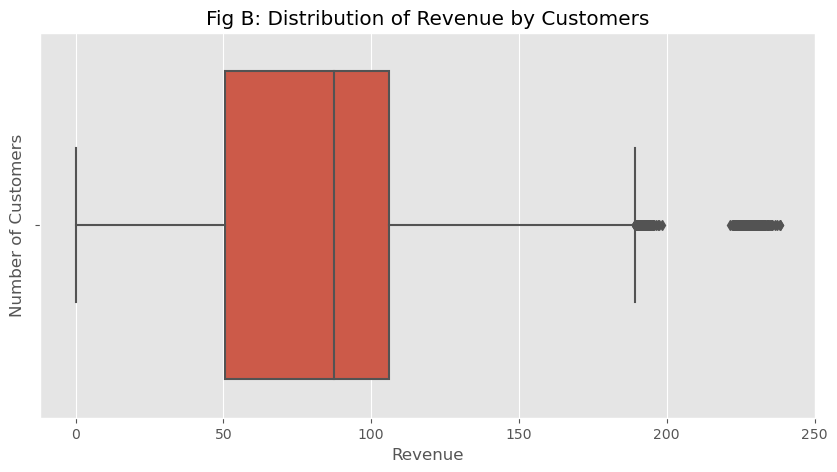

In [11]:
# set plot style and figure size
plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 5))

# boxplot
sns.boxplot(data=df, x="revenue").set(xlabel='Revenue', ylabel='Number of Customers')
plt.title("Fig B: Distribution of Revenue by Customers")

plt.show()

In [12]:
# remove outliers where there is no revenue
df_revenue = df[df.revenue >0]

display(
    df.shape,
    df_revenue.shape
)

(14998, 10)

(13924, 10)

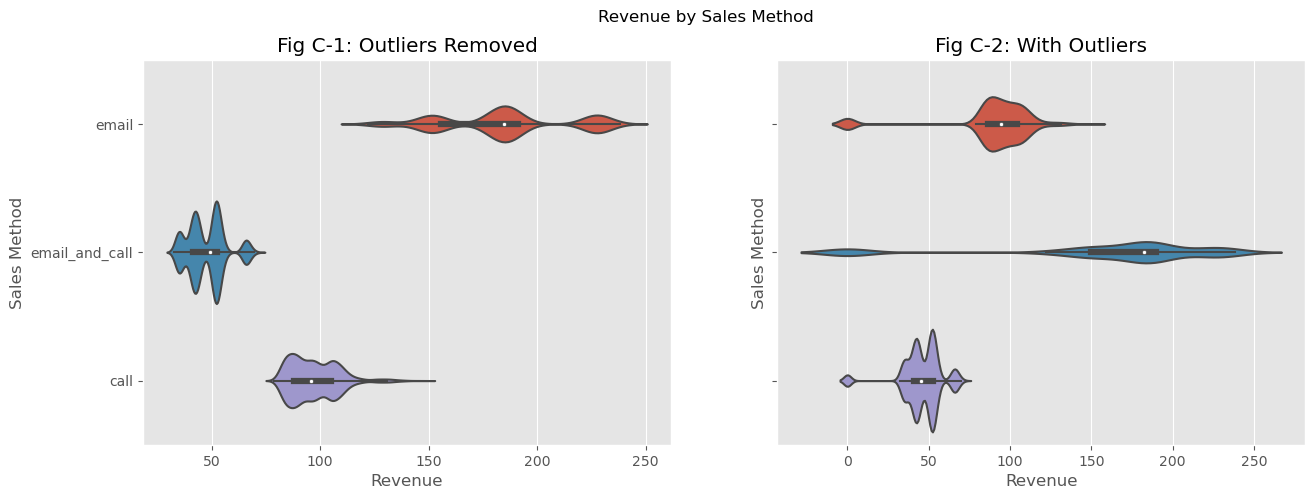

In [13]:
#set plt
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Revenue by Sales Method')

# Without Outliers
sns.violinplot(data=df_revenue,ax=axes[0], x='revenue', y='sales_method')
axes[0].set(title='Fig C-1: Outliers Removed', xlabel='Revenue', ylabel='Sales Method')

# With Outliers
sns.violinplot(data=df,ax=axes[1], x='revenue', y='sales_method')
axes[1].set(title='Fig C-2: With Outliers', xlabel='Revenue', ylabel='Sales Method')

plt.show()

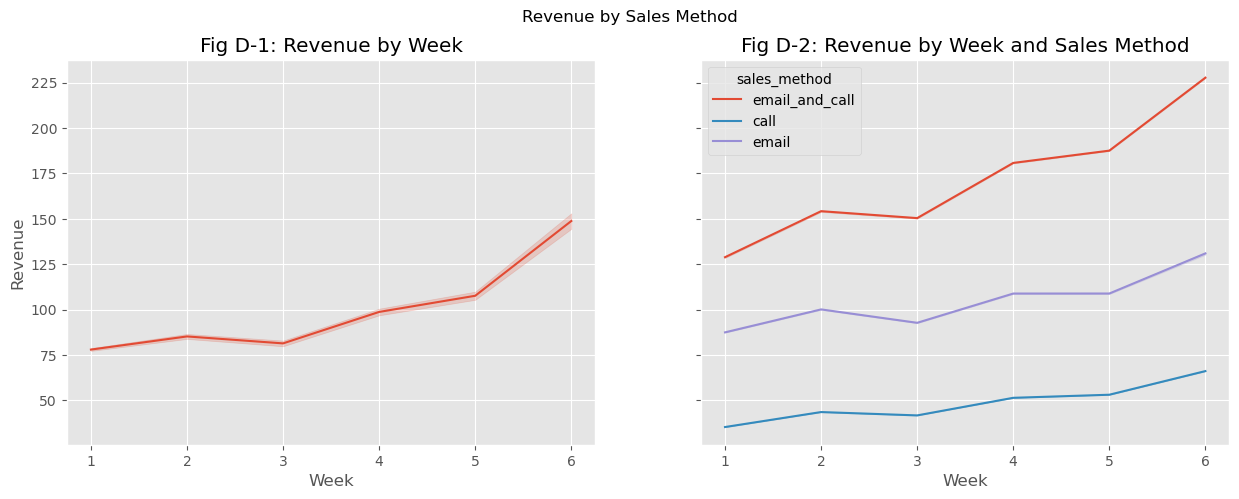

In [14]:
# set up
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Revenue by Sales Method')

# line plot
sns.lineplot(data=df_revenue,ax=axes[0], x='week', y='revenue')
axes[0].set(title='Fig D-1: Revenue by Week',xlabel='Week', ylabel='Revenue')

# sales methods
sns.lineplot(data=df_revenue,ax=axes[1], x='week', y='revenue', hue='sales_method')
axes[1].set(title='Fig D-2: Revenue by Week and Sales Method',xlabel='Week', ylabel='Revenue')

plt.show()

In [15]:
################# Map

# group by state to merge to geodataframe
df_states = df_revenue.groupby(['state','sales_method'])['years_as_customer','revenue'].agg({'revenue':'sum','years_as_customer':['sum','mean','count']}).unstack()
df_states.columns = df_states.columns.get_level_values(2) + '_' + df_states.columns.get_level_values(0) + '_' + df_states.columns.get_level_values(1)

# make total revenue column from original dataframe dict
rev_dict = dict(df_revenue.groupby(['state'])['revenue'].sum())
cust_dict = dict(df_revenue.groupby(['state'])['years_as_customer'].mean())

df_states['total_revenue'] = df_states.index.map(rev_dict)
df_states['years_customer_mean'] = df_states.index.map(cust_dict)

/var/folders/cm/dxwv2v512jvdqq0n4y_wjcl40000gn/T/ipykernel_31761/2452531814.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_states = df_revenue.groupby(['state','sales_method'])['years_as_customer','revenue'].agg({'revenue':'sum','years_as_customer':['sum','mean','count']}).unstack()


In [ ]:
# read in geodataframe
geo_states = geopandas.read_file(working_directory/ 'spatial_merge_states.json')

# only keep certain columns
cols_keep = ['state','geometry']
geo_states = geo_states[cols_keep]

# merge geos by state
merged = geo_states.merge(df_states, left_on='state',right_on='state' )

In [ ]:
# Create point GeoDataFrame at centroid of states
geo_state_pt = merged.copy()
geo_state_pt["geometry"] = geo_state_pt.centroid

# Set choropleth basemap
basemap = merged.plot(column = "years_customer_mean", cmap = "YlGnBu")

# Plot transparent proportional symbols on top of basemap
geo_state_pt.plot(ax = basemap, markersize = (numpy.sqrt(merged["total_revenue"])), color = "lightgray", edgecolor = "darkgray", alpha = 0.7,legend = True, legend_kwds={"fmt": "{:.0f}"},scheme='natural_breaks', k=4)

plt.title('Fig E-1: Revenue (Points) by Average Years as Customer and State')
plt.axis('off')
plt.show();

In [ ]:
# Set choropleth basemap
basemap = merged.plot(column = "total_revenue", cmap = "YlGnBu")

# Plot transparent proportional symbols on top of basemap
geo_state_pt.plot(ax = basemap, markersize = (merged["years_customer_mean"]*10), color = "lightgray", edgecolor = "darkgray", alpha = 0.7,legend = True, legend_kwds={"fmt": "{:.0f}"},scheme='quantiles', k=4)



plt.title('Fig E-2: Average Years as Customer (Points) by Revenue and State')
plt.axis('off')
plt.show();

In [ ]:
fig, axes = plt.subplots(1, 3,figsize=(15,20))

fig.tight_layout() 

# plot geos
merged.plot(column='call_revenue_sum',cmap='YlGnBu', color='lightgray', scheme='quantiles',k=3, edgecolor = 'darkgray',legend = True, legend_kwds={"fmt": "{:.0f}"},alpha = 0.7, ax=axes[0])
axes[0].set_title("Fig F-1: Revenue by Call")
axes[0].xaxis.set_major_locator(plt.NullLocator()) # remove x axis ticks
axes[0].yaxis.set_major_locator(plt.NullLocator()) # remove y axis ticks

merged.plot(column='email_and_call_revenue_sum',cmap='YlGnBu', color='lightgray', scheme='quantiles',k=3,edgecolor = 'darkgray',legend = True, legend_kwds={"fmt": "{:.0f}"}, alpha = 0.7, ax=axes[1])
axes[1].set_title("Fig F-2: Revenue by Call and Email")
axes[1].xaxis.set_major_locator(plt.NullLocator()) # remove x axis ticks
axes[1].yaxis.set_major_locator(plt.NullLocator()) # remove y axis ticks

merged.plot(column='email_revenue_sum',cmap='YlGnBu', color='lightgray', scheme='quantiles',k=3,edgecolor = 'darkgray',legend = True, legend_kwds={"fmt": "{:.0f}"}, alpha = 0.7, ax=axes[2])
axes[2].set_title("Fig F-3: Revenue by Email")
axes[2].xaxis.set_major_locator(plt.NullLocator()) # remove x axis ticks
axes[2].yaxis.set_major_locator(plt.NullLocator()) # remove y axis ticks


# plt.axis('off')
plt.show()

<div class="alert alert-block alert-info"> <b>Definition of a metric for the business to monitor</b>
    
<br>How should the business use the metric to monitor the business problem? 

Expectations on what this report was supposed to generate was unclear outside of an interest about revenue and curiosity about the `sales_method` used due some methods using more staff time. 

With this in mind, if there is a curiosity about cost-efficiency, and only a few ways to understand our customer base (ex: `state` and `years_as_customer`) my suggestion is to focus on the proportion of `revenue` generated by time spent for each `sales_method`. 
I suggest this because there appeared to be very little variation about the geographic location of observations recorded, but `years_as_customer` had a fairly disbursed range of customers for a pen and paper store in 2023.

This can be tracked by estimating a `revenue_to_hours` ratio. I used the `sales_time` column created previously (where `call` = 30 minutes, `email` = 10 minutes, `email_and_call` = 20 minutes) and dividing it by 60 to transform the `sales_time` (in minutes) to `hours`. When each `sales_method` group with its associated `revenue`, we can divide `revenue` by `hours` to easier track how _profitable_ time was spent by each activity, and adjust accordingly.

Since I've hypothesized the `sales_method` that is the most time-consuming and least profitable is `call`, we could analyze what customer categories are already spending the most and assess what the preferred `sales_method` was for each group. 
- If business were to substitute `sales_method` by eliminating `call` for just these categories, where `call` would be replaced with `email` (cutting time down from 30mins/observation to 10mins/observation) and `email_and_call` as `email` (from 20mins/observation to 10mins/observation assuming the email is automated to send out and will take no staff time) we could cut back on the time spent and generate more value from hours worked to profit generated. 
- On initial review, we can see the `customer_categories` broken down by `revenue`, `time_spent`, and the `revenue_to_hours` ratio. 
	- We can see the first category of customers under one year (`(-1.0, 1.0]`) generated the most revenue and the most used sales_method was `emails_and_calls`. 
	- Customers from 3 to 7 years (`(3.0, 7.0]`) generated the second most revenue and the most used sales_method was `call`
- If we replicate the dataset projecting a different trend by `sales_method`, we could replace `call_and_email` for `customer_categories` == `(-1.0, 1.0]` and `call` for `customer_categories` == `(3.0, 7.0]` along with the associated deductions on time spent, the savings could be astronomical.
- From <u>Figure H: Total Revenue/Hours by Historical vs Projected Sales</u> we can see an increase from 414 dollars of revenue/time spent earned per hours to 472 dollars of revenue/time spent earned per hour.

In [ ]:
# categorize the youngest customers, see their sales methods, and revenue spent
df_revenue['customer_categories'] = pandas.qcut(df_revenue['years_as_customer'],4,precision=0)

# make categorical
df_revenue['customer_categories'] = df_revenue['customer_categories'].astype(str)

In [ ]:
# group by
grouped_years = pandas.DataFrame(df_revenue.groupby(['customer_categories','sales_method','week'])['revenue','sales_time'].sum()).reset_index()

# add column for hours
grouped_years['hours'] = (grouped_years['sales_time']/60).round(0)

grouped_years['revenue_to_hours'] = grouped_years['revenue']/grouped_years['hours']

In [ ]:
# set up
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
fig.suptitle('Revenue by Customer Categories',y=1)

# plt.title("Fig G-1: Revenue by Customer Categories and Sales Method")
sns.barplot(x='customer_categories',y='revenue',data=grouped_years,hue='sales_method',ax=axes[0])
axes[0].set(title='Fig G-1: Revenue by Customer \n Categories and Sales Method',xlabel='customer_categories', ylabel='revenue')


# plt.title("Fig G-2: Revenue/Hours Ratio by Customer Categories and Sales Method")
sns.barplot(x='customer_categories',y='revenue_to_hours',data=grouped_years,hue='sales_method',ax=axes[1])
axes[1].set(title='Fig G-2: Revenue/Hours Ratio by Customer\n Categories and Sales Method',xlabel='customer_categories', ylabel='revenue_to_hours')

# plt.title("Fig G-3: Time Spent by Customer Categories and Sales Method")
sns.barplot(x='customer_categories',y='hours',data=grouped_years,hue='sales_method',ax=axes[2])
axes[2].set(title='Fig G-3: Time Spent by Customer \n Categories and Sales Method',xlabel='customer_categories', ylabel='hours')

plt.tight_layout()
plt.show()

In [ ]:
# create masks for customer sales methods
masked = df_revenue.copy()

In [ ]:
mask_new = ((masked.customer_categories == '(-1.0, 1.0]') & (masked.sales_method == 'email_and_call'))
mask_mid = ((masked.customer_categories == '(3.0, 7.0]') & (masked.sales_method == 'call'))

masked['sales_method'][mask_new] = 'email_replace'
masked['sales_method'][mask_mid] = 'email_replace'

mask_new = ((masked.customer_categories == '(-1.0, 1.0]') & (masked.sales_method == 'email_replace'))
mask_mid = ((masked.customer_categories == '(3.0, 7.0]') & (masked.sales_method == 'email_replace'))

masked['sales_time'][mask_new] = 10
masked['sales_time'][mask_mid] = 10

In [ ]:
# review what revenue would look like for each customer cohort

# group by
grouped_mask = pandas.DataFrame(masked.groupby(['customer_categories','sales_method','week'])['revenue','sales_time'].sum()).reset_index()

# add column for hours
grouped_mask['hours'] = (grouped_mask['sales_time']/60).round(0)

grouped_mask['revenue_to_hours'] = grouped_mask['revenue']/grouped_mask['hours']

In [ ]:
# line plot
sns.lineplot(data=grouped_mask, x='week', y='revenue_to_hours',ci=None)
sns.lineplot(data=grouped_years, x='week', y='revenue_to_hours',ci=None)
plt.title("Fig H: Total Revenue/Hours by Historical and Projected Sales")
plt.xlabel("Week")
plt.ylabel("Revenue/Hours")
plt.show()

In [ ]:
grouped_mask.revenue_to_hours.sum() - grouped_years.revenue_to_hours.sum()

In [ ]:
display(
    pandas.DataFrame(grouped_mask.groupby(grouped_mask['customer_categories'])['revenue_to_hours'].sum().round(0)) - pandas.DataFrame(grouped_years.groupby(['customer_categories'])['revenue_to_hours'].sum().round(0))
)

<div class="alert alert-block alert-info"> <b>Final summary of recommendations to the business.</b>
    
<br>I believe business focus should be on customers, and the differences across the customers you serve. I'd be interested to understand data on customers that generated no revenue, while the top `sales_method` for them was the most used and revenue-generating:`email`. 

Additionally, I believe data on exactly how long each sales method took per customer, tracking observations for both email and call for customers with `sales_method` categorized as  `email_and_call` would be helpful to further breakdown the revenue/hours ratio.

Ultimately, for business metrics my suggestion is to focus on revenue/time spent, and eliminate calls as a `sales_method` wherever necessary unless new data collected suggests otherwise.</br>